In [16]:
import os
import pdb
import numpy as np
import gcp.bigquery as bq
import gcp.storage as storage
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import Imputer, OneHotEncoder
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import RFECV

try:
   import cPickle as pickle
except:
   import pickle
EST_PICKLE_FILENAME1 = 'BaggingGradientBoostingRegressor_initial.pkl'
EST_PICKLE_FILENAME2 = 'BaggingGradientBoostingRegressor_final.pkl'

seed = 13
np.random.seed(seed)

In [4]:

# Put all categorical data first for easier implementation of One Hot Encoding.
fields_str = """
gap	day_in_week	weather_1_slots_ago	weather_2_slots_ago	weather_3_slots_ago	busy_time	
tj_level1_1_slots_ago	tj_level2_1_slots_ago	tj_level3_1_slots_ago	tj_level4_1_slots_ago	
tj_level1_2_slots_ago	tj_level2_2_slots_ago	tj_level3_2_slots_ago	tj_level4_2_slots_ago	
tj_level1_3_slots_ago	tj_level2_3_slots_ago	tj_level3_3_slots_ago	tj_level4_3_slots_ago	
temperature_1_slots_ago	pm25_1_slots_ago	
temperature_2_slots_ago	pm25_2_slots_ago	
temperature_3_slots_ago	pm25_3_slots_ago	
gap_1_slots_ago	sum_price_1_slots_ago	
gap_2_slots_ago	sum_price_2_slots_ago	
gap_3_slots_ago	sum_price_3_slots_ago	
f1	f11	f11_1	f11_2	f11_3	f11_4	f11_5	f11_6	f11_7	
f11_8	f13_4	f13_8	f14	f14_1	f14_10	f14_2	f14_3	f14_6	f14_8	f15	f15_1	
f15_2	f15_3	f15_4	f15_6	f15_7	f15_8	f16	f16_1	f16_10	f16_11	f16_12	f16_3	
f16_4	f16_6	f17	f17_2	f17_3	f17_4	f17_5	f19	f19_1	f19_2	f19_3	f19_4	f1_1	
f1_10	f1_11	f1_2	f1_3	f1_4	f1_5	f1_6	f1_7	f1_8	f20	f20_1	f20_2	
f20_4	f20_5	f20_6	f20_7	f20_8	f20_9	f21_1	f21_2	f22	f22_1	f22_2	f22_3	
f22_4	f22_5	f23	f23_1	f23_2	f23_3	f23_4	f23_5	f23_6	f24	f24_1	f24_2	f24_3	
f25	f25_1	f25_3	f25_7	f25_8	f25_9	f2_1	f2_10	f2_11	f2_12	f2_13	f2_2	
f2_4	f2_5	f2_6	f2_7	f2_8	f3_1	f3_2	f3_3	f4	f4_1	f4_10	f4_11	
f4_13	f4_14	f4_16	f4_17	f4_18	f4_2	f4_3	f4_5	f4_6	f4_7	f4_8	f4_9	
f5	f5_1	f5_3	f5_4	f6	f6_1	f6_2	f6_4	f7	f8	f8_1	f8_2	f8_3	f8_4	
f8_5
"""
fields = map(lambda x: x.strip(), fields_str.split('\t'))
features = fields[1:]

# Use this instead of len(features) since this variable can change
# e.g. when one hot encoding is used and/or new features are added.
n_features = len(features)

# Scorer Creation (MAPE)

In [5]:
def mape(y, predictions):
#   num_timeslots = 43
#   num_districts = 66
  if len(y.shape) == 1:
    y = np.asmatrix(y)
  if len(predictions.shape) == 1:
    predictions = np.asmatrix(predictions)
  y = y.astype(float)
  predictions = predictions.astype(float)
  return np.mean(np.absolute((y-predictions)/y))

# from keras import backend as K

# def mape(y, predictions):
#   return K.mean(K.abs(y-predictions/K.clip(K.abs(y), K.epsilon(), np.inf)), axis=-1)

mape_scorer = make_scorer(mape, greater_is_better=False)

In [19]:
%%sql --module q_all

SELECT *, HASH(CAST(district_id AS STRING) +timeslot) AS hash_value,
  IF(ABS(HASH(CAST(district_id AS STRING) + timeslot)) % 2 == 1, 'True', 'False')
    AS included_in_sample, IF(timeofday_slot >= 50 AND timeofday_slot <= 53, 1, 0) AS busy_time
FROM [datalab-projects-1331:xjk_algo_comp.gaps]
WHERE gap > 0
LIMIT 5000

# The above query randomizes its outputs.

In [20]:
query = bq.Query(q_all)
tableresult = query.results()

all_data = np.zeros((tableresult.length, len(fields)))
print 'there are {} rows'.format(tableresult.length)
for rcounter, row in enumerate(tableresult):
  for fcounter, field in enumerate(fields):
    all_data[rcounter, fcounter] = row[field]
  if rcounter % 5000 == 0:
    print 'processed {} rows'.format(rcounter)
all_data_original = np.copy(all_data)

there are 5000 rows
processed 0 rows


# Preprocess Data

In [21]:
one_hot = OneHotEncoder(categorical_features=[1, 2, 3, 4], sparse=False,
                        n_values=[7, 10, 10, 10])
one_hot.fit(Imputer().fit_transform(all_data_original))
print "n_values_:"
print one_hot.n_values_
print "feature_indices_:"
print one_hot.feature_indices_
all_data = StandardScaler().fit_transform(one_hot.fit_transform(Imputer().fit_transform(
      all_data_original)))
n_features = all_data.shape[1] - 1
print 'new number of features: {}'.format(n_features)

n_values_:
[ 7 10 10 10]
feature_indices_:
[ 0  7 17 27 37]
new number of features: 196


# Split Data

In [22]:
# Split the data into train and test sets.
data_size = all_data.shape[0]
training_size = data_size * 80/100
indices = np.random.permutation(data_size)
training_idx, test_idx = indices[:training_size], indices[training_size:]
all_data_train, all_data_test = all_data_original[training_idx,:], all_data_original[test_idx,:]

data_train = all_data_train[:,1:]
targets_train = all_data_train[:,0]
data_test = all_data_test[:,1:]
targets_test = all_data_test[:,0]

# Feature Selection

In [23]:
rfecv = RFECV(SVR(kernel='linear'), scoring=mape_scorer, verbose=1)
rfecv.fit(all_data[training_idx,1:], targets_train)

Finished fold with 1 / 196 feature ranks, score=-0.046896
Finished fold with 2 / 196 feature ranks, score=-0.023659
Finished fold with 3 / 196 feature ranks, score=-0.017603
Finished fold with 4 / 196 feature ranks, score=-0.006706
Finished fold with 5 / 196 feature ranks, score=-0.012832
Finished fold with 6 / 196 feature ranks, score=-0.016082
Finished fold with 7 / 196 feature ranks, score=-0.017269
Finished fold with 8 / 196 feature ranks, score=-0.018012
Finished fold with 9 / 196 feature ranks, score=-0.016229
Finished fold with 10 / 196 feature ranks, score=-0.027767
Finished fold with 11 / 196 feature ranks, score=-0.027933
Finished fold with 12 / 196 feature ranks, score=-0.026494
Finished fold with 13 / 196 feature ranks, score=-0.026253
Finished fold with 14 / 196 feature ranks, score=-0.026390
Finished fold with 15 / 196 feature ranks, score=-0.026775
Finished fold with 16 / 196 feature ranks, score=-0.026718
Finished fold with 17 / 196 feature ranks, score=-0.019817
Finish

RFECV(cv=None,
   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
   estimator_params=None,
   scoring=make_scorer(mape, greater_is_better=False), step=1, verbose=1)

Optimal number of features : 4


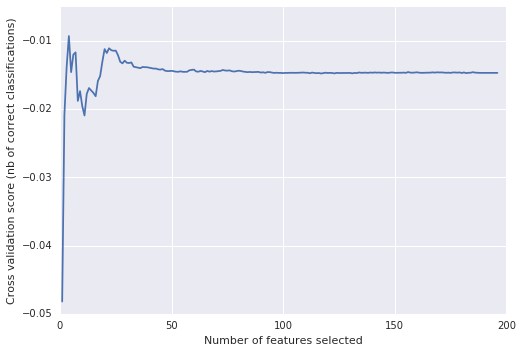

In [24]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [25]:
rfecv.grid_scores_

array([-0.04820252, -0.02079843, -0.01380174, -0.00927224, -0.0145694 ,
       -0.01199945, -0.01166627, -0.01878477, -0.01734849, -0.0195538 ,
       -0.02092372, -0.01777325, -0.01689787, -0.01724139, -0.01760842,
       -0.01809834, -0.01585822, -0.01514929, -0.01304456, -0.01118938,
       -0.01176045, -0.01106637, -0.01134785, -0.011435  , -0.01140495,
       -0.01207491, -0.01304405, -0.01327839, -0.0128857 , -0.01319245,
       -0.01322818, -0.01314254, -0.01376516, -0.01383943, -0.01391283,
       -0.01398327, -0.01380692, -0.01384078, -0.01384422, -0.01391986,
       -0.01398264, -0.01404736, -0.01404069, -0.01415581, -0.01419274,
       -0.01411536, -0.01434265, -0.0144108 , -0.01441102, -0.01437007,
       -0.01444125, -0.01450191, -0.01451479, -0.01444968, -0.01451545,
       -0.01452402, -0.01450979, -0.01429599, -0.0142498 , -0.01419244,
       -0.01446256, -0.01450367, -0.01438751, -0.01448494, -0.01456733,
       -0.0143895 , -0.01449669, -0.01440952, -0.0144796 , -0.01

In [26]:
print rfecv.ranking_
print rfecv.get_support()

[ 25 183  26 190  24  30 187  80  20  34  35 113  39 186 116  49 192 121
  48  43  53  82 184 188 104  19 189 103  36  54  38  79 185 191  81  77
   1 193  23   1  29   2  33   1  32  28   4  18   3  16  17  21   6  22
  14   5   1   8   9   7  11  10  59 157 132 161 152 118 140 153 147  68
  94  42  90  58  63 178 163 136 133  71 102 177 165 146 111 180  88 137
 144  69  86 101  78  12  72 131 162 170 176 168 125 148 129 135  52  89
  76 175 150 100 105 151 164 107 179  55 117 149  47  51 156  92 167 138
  65 181 139  40  95 155 114  87 173 182  98  83 158  57 123  27  46  15
  31 160  91 169 130 109 166  67  62 127  44  64  84  37 119  75 141 128
 143  97  66  96 126  13  45  41  70  73 174 122  60  56 134 115 154  85
 106 112  50 110  93  74 120 124 145 171 142 108  61 172  99 159]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False Fal

# Create Initial Bagging Algo

In [ ]:
if os.path.isfile(EST_PICKLE_FILENAME1):
  bagging_est = pickle.load(open(EST_PICKLE_FILENAME1, 'r'))
else:
  steps = [
    ('impute', Imputer()),
    # Remember that gap, the first variable, was removed, thus categorical_features
    # should start at index 0.
    ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                             n_values=[7, 10, 10, 10])),
    ('scale', StandardScaler()),
    ('select_features', RFECV(SVR(kernel='linear'), scoring=mape_scorer, verbose=1))
    ('estimate', GradientBoostingRegressor(n_estimators=190, learning_rate=0.5))

  ]

  est = Pipeline(steps)

  steps_bagging = [
    ('impute', Imputer()),
    # Remember that gap, the first variable, was removed, thus categorical_features
    # should start at index 0.
    ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                             n_values=[7, 10, 10, 10])),
    ('scale', StandardScaler()),
    ('estimate', BaggingRegressor(
        GradientBoostingRegressor(
          n_estimators=n_features, learning_rate=0.5,
          verbose=1
        )))

  ]

  bagging_est = Pipeline(steps_bagging)
  bagging_est.fit(data_train, targets_train)
  pickle.dump(bagging_est, open(EST_PICKLE_FILENAME1, "w") )

Test data's prediction MAPE score:

In [ ]:
test_predictions = bagging_est.predict(data_test)
print(mape(targets_test, test_predictions))

# RandomizedSearchCV

In [ ]:
steps_bagging = [
  ('impute', Imputer()),
  # Remember that gap, the first variable, was removed, thus categorical_features
  # should start at index 0.
  ('one_hot', OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False,
                           n_values=[7, 10, 10, 10])),
  ('scale', StandardScaler()),
  ('estimate', BaggingRegressor(
      GradientBoostingRegressor(
        n_estimators=n_features, learning_rate=0.5,
        verbose=1
      )))

]

params = {
  'estimate__learning_rate': [0.1, 0.5, 1, 10],
  'estimate__n_estimators': [i for i in range(110, n_features, 20)],
#   'estimate__loss': ['linear', 'square', 'exponential']
}

search_params = RandomizedSearchCV(
  estimator=est,
  param_distributions=params,
  cv=5,
  scoring=mape_scorer,
  n_jobs=2,
  verbose=1
)

search_params.fit(data_train_original, targets_train)
print(search_params.grid_scores_)
print(search_params.best_params_)
print(search_params.best_score_)
search_params.best_estimator_